C:\Users\User\AppData\Local\Temp\ipykernel_10612\2129228480.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_excel(


Epoch 1/100
47/47 [==============================] - 5s 27ms/step - loss: 0.1806 - mae: 0.4566 - mse: 0.4172 - val_loss: 0.4779 - val_mae: 0.8207 - val_mse: 1.4441
Epoch 2/100
47/47 [==============================] - 1s 16ms/step - loss: 0.0947 - mae: 0.3217 - mse: 0.2027 - val_loss: 0.4896 - val_mae: 0.8336 - val_mse: 1.4898
Epoch 3/100
47/47 [==============================] - 1s 19ms/step - loss: 0.0883 - mae: 0.3048 - mse: 0.1889 - val_loss: 0.5004 - val_mae: 0.8437 - val_mse: 1.5266
Epoch 4/100
47/47 [==============================] - 1s 18ms/step - loss: 0.0847 - mae: 0.2970 - mse: 0.1832 - val_loss: 0.4907 - val_mae: 0.8323 - val_mse: 1.4893
Epoch 5/100
47/47 [==============================] - 1s 16ms/step - loss: 0.0816 - mae: 0.2894 - mse: 0.1746 - val_loss: 0.4814 - val_mae: 0.8215 - val_mse: 1.4498
Epoch 6/100
47/47 [==============================] - 1s 16ms/step - loss: 0.0799 - mae: 0.2873 - mse: 0.1704 - val_loss: 0.4316 - val_mae: 0.7625 - val_mse: 1.2616
Epoch 7/100
47/4

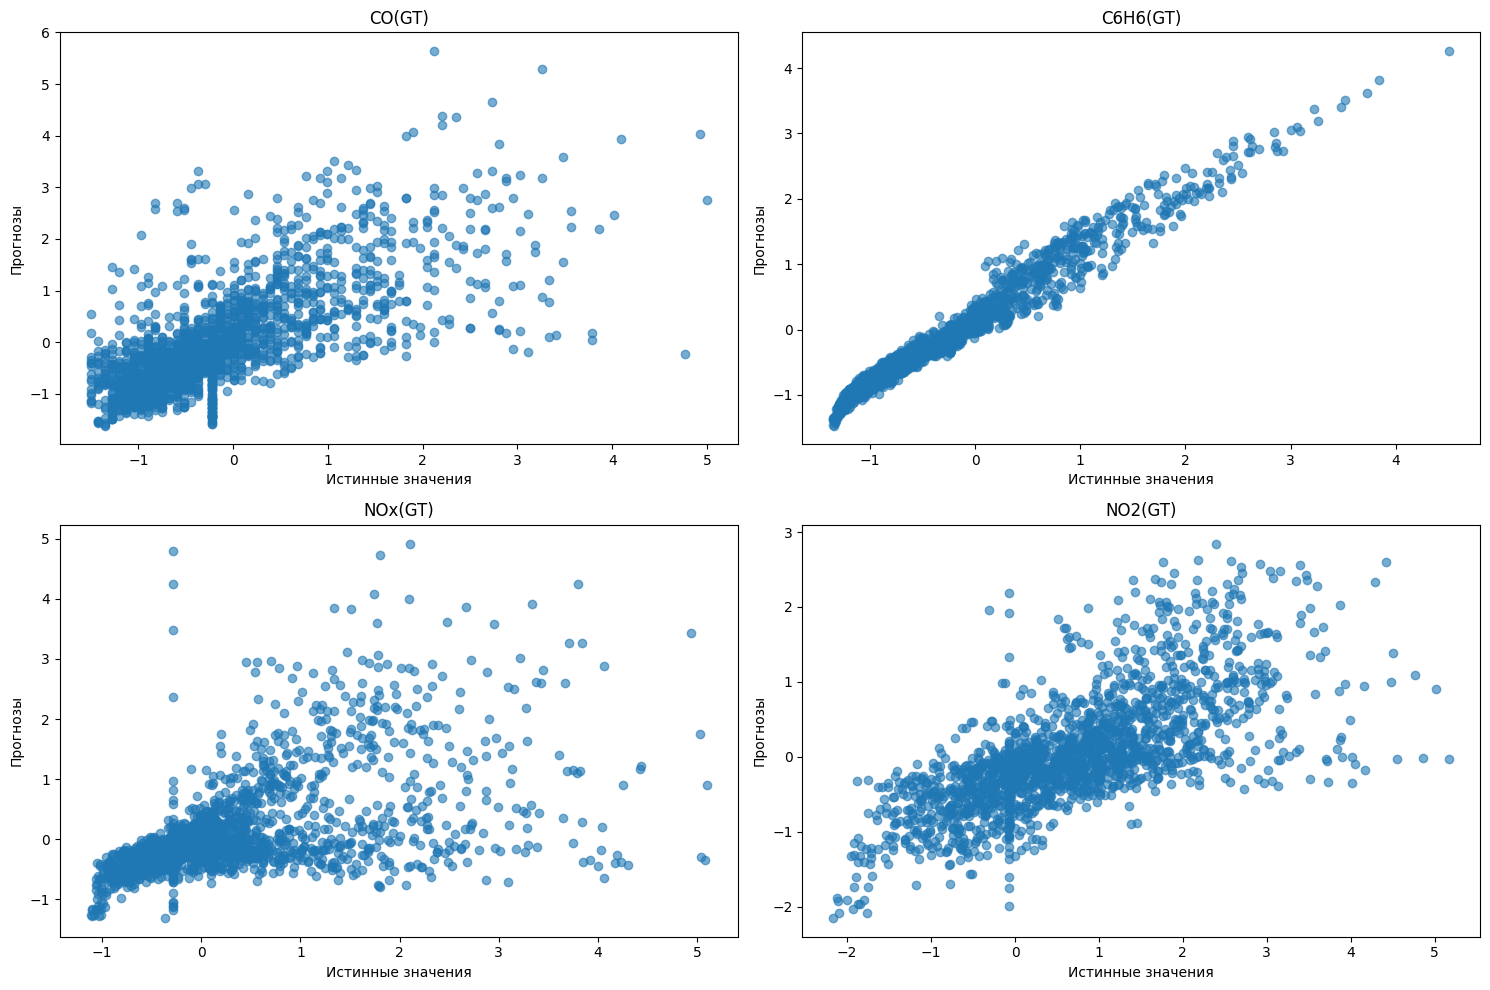

In [6]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# 1. Загрузка Excel-файла (предварительно загрузите файл AirQualityUCI.xlsx)
try:
    df = pd.read_excel(
        'AirQualityUCI.xlsx', 
        decimal=',',
        parse_dates=[['Date', 'Time']],
        na_values=-200,
        sheet_name='AirQualityUCI'
    )
except Exception as e:
    print(f"Ошибка загрузки: {e}")
    exit()

# 2. Продвинутая предобработка
def advanced_preprocessing(df):
    # Удаление технических столбцов
    cols_to_drop = ['Unnamed: 15', 'Unnamed: 16', 'NMHC(GT)']
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Обработка временны́х меток
    df['Weekday'] = df['Date_Time'].dt.weekday
    df['Hour'] = df['Date_Time'].dt.hour
    df = df.drop('Date_Time', axis=1)
    
    # Расширенное заполнение пропусков
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df), 
        columns=df.columns,
        index=df.index
    )
    
    # Целевые показатели
    target_cols = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
    
    # Разделение данных с учётом мультиколлинеарности
    feature_cols = [col for col in df_imputed.columns if col not in target_cols]
    
    X = df_imputed[feature_cols].astype(np.float32)
    y = df_imputed[target_cols].astype(np.float32)
    
    # Масштабирование
    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)
    
    return X_scaler.transform(X), y_scaler.transform(y), feature_cols, target_cols

X, y, features, targets = advanced_preprocessing(df)

# 3. Разделение данных с временной стратификацией
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False,  # Сохранение временного порядка
    random_state=42
)

# 4. Многофункциональная модель
model = Sequential([
    Dense(512, activation='swish', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='swish'),
    BatchNormalization(),
    Dense(128, activation='swish'),
    BatchNormalization(),
    Dense(64, activation='swish'),
    Dense(y_train.shape[1], activation='linear')
])

# 5. Настройка оптимизатора
model.compile(
    optimizer='adam',
    loss='huber_loss',  # Устойчивость к выбросам
    metrics=['mae', 'mse']
)

# 6. Обучение с расширенной диагностикой
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)
training_duration = time.time() - start_time

# 7. Полная оценка модели
def detailed_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mae_total = mean_absolute_error(y_test, y_pred)
    mse_total = mean_squared_error(y_test, y_pred)
    
    # Индивидуальные метрики для каждой цели
    results = {}
    for i, target in enumerate(targets):
        results[target] = {
            'MAE': mean_absolute_error(y_test[:,i], y_pred[:,i]),
            'MSE': mean_squared_error(y_test[:,i], y_pred[:,i])
        }
    return mae_total, mse_total, results

mae_total, mse_total, per_target = detailed_evaluation(model, X_test, y_test)

# 8. Вывод результатов
print(f'''
╭{'─'*70}╮
│ Результаты обучения (100 эпох) {' ' * 38}│
├{'─'*70}┤
│ Время обучения:         {training_duration:.2f} сек ({training_duration/60:.1f} мин)          │
│ Общий MAE:              {mae_total:.4f}                               │
│ Общий MSE:              {mse_total:.4f}                             │
├{'─'*70}┤
│ Индивидуальные показатели:                        │''')

for target, metrics in per_target.items():
    print(f'│ {target:10} MAE: {metrics["MAE"]:.4f} | MSE: {metrics["MSE"]:.4f}       │')



# 9. Детальная визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    if i < len(targets):
        ax.scatter(y_test[:,i], model.predict(X_test)[:,i], alpha=0.6)
        ax.set_title(targets[i])
        ax.set_xlabel('Истинные значения')
        ax.set_ylabel('Прогнозы')
plt.tight_layout()
plt.show()
